In [ ]:
pip install torchaudio

In [ ]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import math
import torch
import torchaudio as audio

audio.set_audio_backend('sox_io')

In [ ]:
import numpy as np

In [ ]:
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
sample_rate = 16000
window_time = 0.01 # seconds
window_size = int(sample_rate * window_time)
plt.figure(figsize=(16, 16))
spectogram = audio.transforms.Spectrogram(
    n_fft=window_size,
    win_length=window_size,
    hop_length=window_size // 2,
    power=2
)
path = '/content/drive/MyDrive/Alina/'
samples = audio.load(path + 'neg_clean/1.wav', channels_first=True, normalize=True)[0][0]
plt.imshow(spectogram(samples)[:,:1000])

In [ ]:
def get_treshold(power):
    begin = power.quantile(0.1)
    end = power.quantile(0.9)
    return begin + (end - begin) * 0.2

In [ ]:
def filter_voice_by_windows_mask(samples, sound):
    half_window_zeros = torch.zeros(window_size // 2, dtype=torch.bool)
    if len(sound) % 2 == 0:
        mask = torch.cat([sound[0::2].repeat_interleave(window_size), half_window_zeros])
        mask |= torch.cat([half_window_zeros, sound[1::2].repeat_interleave(window_size)])
    else:
        mask = sound[0::2].repeat_interleave(window_size)
        mask |= torch.cat([half_window_zeros, sound[1::2].repeat_interleave(window_size), half_window_zeros])
    n = min(len(mask), len(samples))
    print(mask.sum() / len(mask))
    return samples[:n][mask[:n]]

In [ ]:
def split(samples, use_spect=True):
    spect = spectogram(samples)
    power = spect[:40,:].mean(dim=0)# до 4 кГц
    treshold = get_treshold(power)
    sound = power > treshold
    
    ends = F.conv1d(
        sound.float().view(1, 1, -1),
        torch.cat([torch.ones(100), torch.full((10,), -100)]).view(1, 1, -1)
    ).view(-1)
    ends = (ends > 45)
    ends = torch.cat([torch.zeros(len(sound) - len(ends), dtype=torch.bool), ends])
    last = 0
    cuted = []
    spect = spect[:40,:].T
    for j in range(len(ends) - 10):
        if ends[j] and j - last >= 70:
            if use_spect:
                subrange = spect[last:j+10]
            else:
                subrange = samples[last * window_size // 2: (j + 5) * window_size // 2]
            last = j
            cuted.append(subrange)
    return cuted
#     if use_spect:
#         return [x for x in cuted if len(x) > 70]
#     else:
#         return [x for x in cuted if len(x) > window_size * 0.35 / window_time]

In [ ]:
len(split(audio.load(path + 'pos_clean/2.wav', channels_first=True, normalize=True)[0][0]))

In [ ]:
for x in split(audio.load(path + 'pos_clean/2.wav', channels_first=True, normalize=True)[0][0], use_spect=False)[:10]:
    ipd.display(ipd.Audio(x, rate=sample_rate))

In [ ]:
words = split(audio.load(path + 'pos_clean/3.wav', channels_first=True, normalize=True)[0][0], use_spect=False)
print(len(words))
for x in np.random.randint(0, len(words), 10):
    ipd.display(ipd.Audio(words[x], rate=sample_rate))

186


In [ ]:
def silence(samples, use_spect=True):
    spect = spectogram(samples)
    power = spect[:40,:].mean(dim=0)# до 4 кГц
    treshold = get_treshold(power)
    mask = F.conv1d((power < treshold).float().view(1, 1, -1),torch.ones(1, 1, 10)).view(-1) > 9.5
    mask = torch.cat([mask, torch.zeros(9, dtype=torch.bool)])
    spect = spect[:40,:].T
    if use_spect:
        return spect[mask]
    else:
        result = []
        cnt = 0
        for i in range(len(power) - 1):
            if mask[i]:
                cnt += 1
                result.append(samples[i * window_size // 2: i * window_size // 2 + window_size])
        return torch.cat(result)

In [ ]:
ipd.display(ipd.Audio(
    silence(audio.load(path + 'pos_clean/5.wav', channels_first=True, normalize=True)[0][0][:sample_rate*10], use_spect=False),
    rate=sample_rate)
)

In [ ]:
import os

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
positive = []
for i in range(1, 12):
    name = path + 'pos_clean/' + str(i) + '.wav'
    positive += split(audio.load(name, channels_first=True, normalize=True)[0][0])

for i in range(1, 12):
    name = path + 'pos_noisy/' + str(i) + '.wav'
    positive += split(audio.load(name, channels_first=True, normalize=True)[0][0])

In [ ]:
import random

In [ ]:
avg_len = sum(map(len, positive)) // len(positive)
print(avg_len * window_time / 2)

1.705


In [ ]:
from copy import deepcopy

In [ ]:
negative = []
for i in range(1, 12):
    name1 = path + 'neg_clean/' + str(i) + '.wav'
    negative += split(audio.load(name1, channels_first=True, normalize=True)[0][0])
for i in range(1, 11):
    name2 = path + 'neg_noisy/' + str(i) + '.wav'
    negative += split(audio.load(name2, channels_first=True, normalize=True)[0][0])
for i in range(1, 12):
    name3 = path + 'neg_random/' + str(i) + '.wav'
    negative += split(audio.load(name3, channels_first=True, normalize=True)[0][0])

# for name in tqdm(os.listdir(path + "ru")):
#     full_name = os.path.join(path + "ru", name)
#     negative += split(audio.load(full_name, channels_first=True, normalize=True)[0][0])
print(len(negative))

def add_silence(name):
    s = silence(audio.load(name, channels_first=True, normalize=True)[0][0])
    c = 0
    while c < len(s):
        negative.append(s[c: c + avg_len])
        c += avg_len

for i in [name1, name2, name3]:
    add_silence(i)
print(len(negative))

15545
16148


In [ ]:
def shuffled(samples, size, use_spect=True, ext=1):
    ans = []
    for i in range(0, len(samples), size):
        for j in range(ext):
            ans.append(samples[i: i + size])
            ans[-1] = torch.flip(ans[-1], [0])
    random.shuffle(ans)
    ans = torch.cat(ans)
    if use_spect:
        return spectogram(ans)[:40,:].T
    else:
        return ans

In [ ]:
'''
random.seed(42)
samples = audio.load(path + '2.wav', channels_first=True, normalize=True)[0][0]
ipd.display(ipd.Audio(samples.flip([0])[:sample_rate*10], rate=sample_rate))
ipd.display(ipd.Audio(shuffled(samples, sample_rate // 20, use_spect=False, ext=20)[:sample_rate*10], rate=sample_rate))
samples = torch.cat(split(samples, use_spect=False))
ipd.display(ipd.Audio(shuffled(samples, sample_rate // 20, use_spect=False)[:sample_rate*10], rate=sample_rate))
'''

"\nrandom.seed(42)\nsamples = audio.load(path + '2.wav', channels_first=True, normalize=True)[0][0]\nipd.display(ipd.Audio(samples.flip([0])[:sample_rate*10], rate=sample_rate))\nipd.display(ipd.Audio(shuffled(samples, sample_rate // 20, use_spect=False, ext=20)[:sample_rate*10], rate=sample_rate))\nsamples = torch.cat(split(samples, use_spect=False))\nipd.display(ipd.Audio(shuffled(samples, sample_rate // 20, use_spect=False)[:sample_rate*10], rate=sample_rate))\n"

In [ ]:
'''
def add_suffled(name, with_silence=False):
    samples = audio.load(name, channels_first=True, normalize=True)[0][0]
    s = torch.cat([
        shuffled(samples, sample_rate // 20),
        shuffled(torch.cat(split(samples, use_spect=False)), sample_rate // 20)])
    c = 0
    while c < len(s):
        negative.append(s[c: c + avg_len])
        c += avg_len
for i in range(1, 6):
    add_suffled(path + '0' + str(i) + '.wav')

print(len(negative))

'''

"\ndef add_suffled(name, with_silence=False):\n    samples = audio.load(name, channels_first=True, normalize=True)[0][0]\n    s = torch.cat([\n        shuffled(samples, sample_rate // 20),\n        shuffled(torch.cat(split(samples, use_spect=False)), sample_rate // 20)])\n    c = 0\n    while c < len(s):\n        negative.append(s[c: c + avg_len])\n        c += avg_len\nfor i in range(1, 6):\n    add_suffled(path + '0' + str(i) + '.wav')\n\nprint(len(negative))\n\n"

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = [1] * len(positive) + [0] * len(negative)
X = positive + negative
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size = 0.1)

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [ ]:
class ActivationWordFinder(nn.Module):
    def __init__(self, num_classes, feature_size, hidden_size,
                num_layers, dropout, device='cpu'):
        super(ActivationWordFinder, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.device = device
        self.layernorm = nn.LayerNorm(feature_size)
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def _init_hidden(self, batch_size):
        n, hs = self.num_layers, self.hidden_size
        return (torch.zeros(n, batch_size, hs).to(self.device),
                torch.zeros(n, batch_size, hs).to(self.device))

    def forward(self, x):
        # x.shape => seq_len, batch, feature
        x = self.layernorm(x)
        hidden = self._init_hidden(x.size()[1])
        out, (hn, cn) = self.lstm(x, hidden)
        out = self.classifier(hn)
        return out

In [ ]:
class AlinaRNN(nn.Module):
    def __init__(self, code_size, hidden_size):
        super(AlinaRNN, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(code_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU()
        )
        self.rnn = nn.GRUCell(128, hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1),
        )
    def forward(self, x, h):
        h = self.rnn(self.encode(x), h)
        return self.decode(h), h

In [ ]:
from itertools import product

In [ ]:
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

net = AlinaRNN(40, 32).float().cuda()
opt = torch.optim.Adam(net.parameters())
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
loss_func = nn.NLLLoss(weight=torch.tensor([1.0, 100.0]))

In [ ]:
def train_n_epoch(n, k, batch_size):
    net.train().cuda()
    losses = []
    sl = 0
    for e, i in tqdm(list(product(range(n), range(0, len(X_train), batch_size)))):
        X_batch = X_train[i: i + batch_size]
        y_batch = torch.tensor(y_train[i: i + batch_size], dtype=torch.bool)
        bs = len(X_batch)
        lens = torch.tensor([len(x) for x in X_batch])
        l = lens.max()
        for j in range(len(X_batch)):
            X_batch[j] = torch.cat([X_batch[j].float(), torch.zeros(l - len(X_batch[j]), 40, dtype=torch.float)])
        X_batch = torch.stack(X_batch, dim=1).cuda()
        h = torch.zeros(bs, 32, dtype=torch.float).cuda()
        loss = 0
        opt.zero_grad()
        cur_lens = lens
        for j, s in enumerate(X_batch):
            mask = lens > j
            cur_mask = cur_lens > j
            s = s[mask]
            h = h[cur_mask]
            y_batch = y_batch[cur_mask]
            cur_lens = cur_lens[cur_mask]
            pred, h = net(s, h)
#             true_res = (j < cur_lens) & (j >= cur_lens - 10) & y_batch
            true_res = y_batch
            learn_mask = ((j < cur_lens) & (j >= cur_lens - 20)) | ~y_batch
            if learn_mask.any():
                loss += loss_func(pred[learn_mask].cpu(), true_res[learn_mask].long())
        loss /= l
        sl += loss.item()
        if (i // batch_size) % k == 0:
            print(sl / k)
            sl = 0
        losses.append(loss.item())
        loss.backward()
        opt.step()
    #     scheduler.step(loss)
    plt.plot(losses)
    s = 0
    for i in range(len(losses)):
        s += losses[i]
        losses[i] = s / (i + 1)
    plt.plot(losses)

In [ ]:
len(X)

20070

0.03436028361320496
0.23281596302986146
0.2323296695947647
0.2272065609693527
0.2067941188812256
0.18178940713405609
0.17197313606739045
0.19640626311302184
0.19478123486042023
0.2071237474679947
0.21013027131557466
0.17621886730194092
0.16399603188037873
0.15442907214164733
0.14509882032871246
0.16126203536987305
0.1503707006573677
0.14563251584768294
0.1382221981883049
0.12795496433973313
0.12310479879379273
0.12205341458320618
0.12379079461097717
0.1286237731575966
0.13312068283557893
0.12660157829523086
0.12408883571624756
0.11990274786949158
0.11324176788330079
0.10546470135450363
0.10371994376182556
0.10355562269687653
0.104144287109375
0.10352342575788498
0.10553915053606033
0.10670848786830903
0.10650722682476044
0.101700821518898



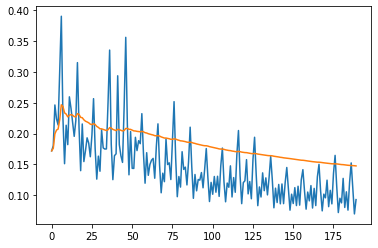

In [ ]:
train_n_epoch(19, 5, 2000)

In [ ]:
torch.save(net.state_dict(), path + 'tensor_normalized.pt')

In [ ]:
'''
model = AlinaRNN(40, 32).float().cuda()
model.load_state_dict(torch.load(path))
model.eval()
'''

'\nmodel = AlinaRNN(40, 32).float().cuda()\nmodel.load_state_dict(torch.load(path))\nmodel.eval()\n'

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
#net.load_state_dict(torch.load('AlinaNet_3:3_128_zoom+shuffle+silence_alinas_97_93_tres(94)_w(100).torch'))

In [ ]:
preds = []
probs = []
net.eval().cpu()
with torch.no_grad():
    for i, (x, y) in tqdm(list(enumerate(zip(X_test, y_test)))):
        h = torch.zeros(1, 32)
        pred_word = 0
        prob = 0
        for j, s in enumerate(x):
            pred, h = net(s.view(1, -1), h)
            prob = max(torch.exp(pred[0][1]).item(), prob)
            if torch.exp(pred[0][1]).item() > 0.88:
                pred_word = 1
        preds.append(pred_word)
        probs.append(prob)
print("precision:", precision_score(y_test, preds))
print("recall:", recall_score(y_test, preds))
print("ROC-AUC:", roc_auc_score(y_test, probs))


precision: 0.39783491204330174
recall: 0.7696335078534031
ROC-AUC: 0.8240708819975836


In [ ]:
print("precision:", precision_score(y_test, preds))
print("recall:", recall_score(y_test, preds))
print("ROC-AUC:", roc_auc_score(y_test, probs))

probs

In [ ]:
np.sort(probs)

array([0.13517871, 0.139056  , 0.1396171 , ..., 0.93207997, 0.94105822,
       0.94508833])

2007 428


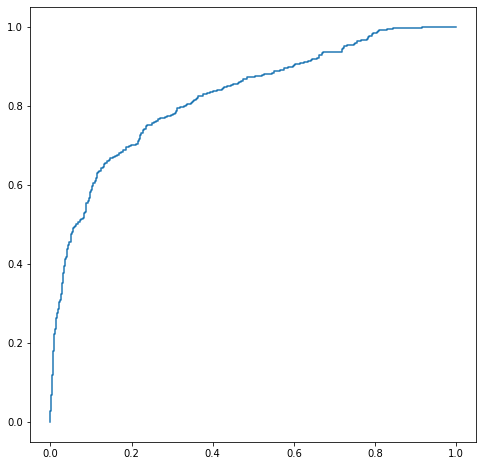

In [ ]:
plt.figure(figsize=(8, 8))
fpr, tpr, tres = roc_curve(y_test, probs)
print(len(y_test), len(tres))
plt.plot(fpr, tpr)

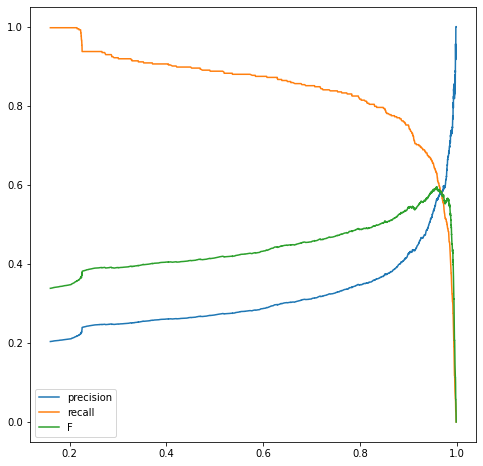

In [ ]:
plt.figure(figsize=(8, 8))
p, r, tres = precision_recall_curve(y_test, probs)
p = p[1:]
r = r[1:]
f = 2 * p * r / (p + r)
plt.plot(tres, p, label='precision')
plt.plot(tres, r, label='recall')
plt.plot(tres, f, label='F')
plt.legend()
plt.show()

In [ ]:
best_treshold = tres[f.argmax()]
best_precision = p[f.argmax()]
best_recall = r[f.argmax()]
print("Best treshold:", best_treshold)
print("Best precision:", best_precision)
print("Best recall:", best_recall)

Best treshold: 0.9583206176757812
Best precision: 0.5630841121495327
Best recall: 0.6308900523560209


In [ ]:
file = input()
if file != '':
    torch.save(net.state_dict(), file)

model_19_epoch


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
for i in range(10 ** 7):
    pass

In [ ]:
name = 'test.wav'
samples = audio.load(name, channels_first=True, normalize=True)[0][0][:sample_rate*40]
# samples = shuffled(samples, sample_rate // 20, use_spect=False)[:sample_rate*10]
spect = spectogram(samples)[:40,:].T
h = torch.zeros(1, 32)
cnt = 0
net.eval()
preds = []
for x in tqdm(spect):
    pred, h = net(x.view(1, -1), h)
    preds.append(torch.exp(pred[0][1]).item())

In [ ]:
ipd.display(ipd.Audio(samples, rate=sample_rate))

In [ ]:
preds = np.array(preds)

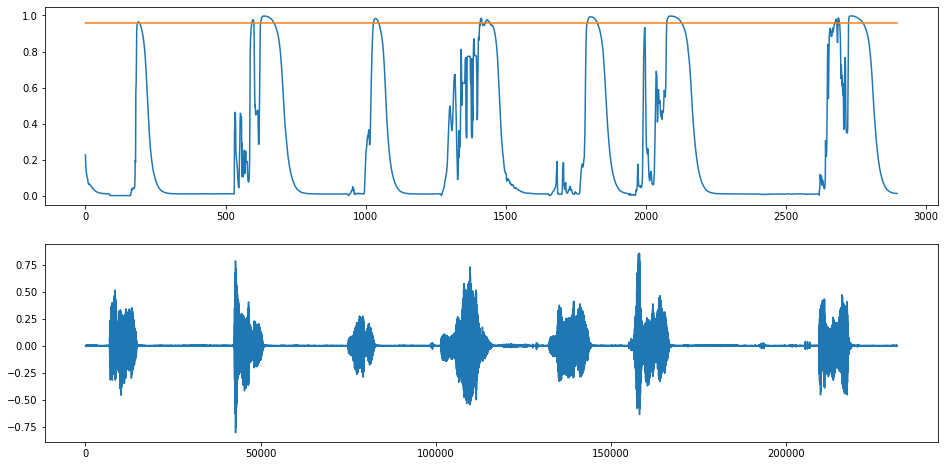

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(preds)
plt.plot([best_treshold] * len(preds))
plt.subplot(2, 1, 2)
plt.plot(samples)

In [ ]:
treshold = best_treshold
# treshold = 0.9
print((preds > treshold).sum())

ends = preds > treshold

last = 0
cuted = []

for j in range(len(ends) - 1):
    if ends[j] and not ends[j + 1] and j - last > 60:
        subrange = samples[last * window_size // 2: j * window_size // 2]
        last = j
        cuted.append(subrange)
len(cuted)

30


2

In [ ]:
for x in cuted[:10]:
    ipd.display(ipd.Audio(x[-sample_rate*2:], rate=sample_rate))